In [2]:
# Importing all necessary libraries
import math
import numpy as np
import pandas as pd
import random
import warnings
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

In [3]:
dataset_location = "/Users/Xutao/Documents/CR4CR/data/DCS Market.01abc_OEOEOE Combined.xlsx"

In [116]:
df = pd.read_excel(dataset_location)
df.head()

,Respondent Id,Assignment Id,Class,Activities,Score,Market.01a_OE,Market.01b_OE,Market.01c_OE
0,23670,51221,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form BC1,No Scores,Missing,Missing,Missing
1,23663,51225,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form CC2,No Scores,Missing,Missing,Missing
2,22520,51334,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form AC1,No Scores,Missing,Missing,Missing
3,22587,51318,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form CC1,No Scores,Missing,Missing,Missing
4,23413,51237,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form CC2,No Scores,Missing,Missing,Missing


In [117]:
# Basic data cleaning to ensure score is not "missing" or NaN, etc

df = df[df['Score'].isin(range(5))]

columns = ["Market.01a_OE", "Market.01b_OE", "Market.01c_OE"]

import re

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # text = re.sub(r'\n', ' ', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading and trailing whitespace
    text = text.strip()

    return text


# Ensure data types of responses are string
for col in columns:
  df[col] = df[col].astype(str).apply(preprocess_text)

In [118]:
df.head()


,Respondent Id,Assignment Id,Class,Activities,Score,Market.01a_OE,Market.01b_OE,Market.01c_OE
24,24977,51207,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form AA1,1,13 people inside the store a group of 5 people...,13 5 is not equal or lower than 15,the doors stay closed until 3 more people leav...
26,25149,51203,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form CB2,0,a set of instructions to obtain an expected ou...,instructions will be provided on how to handle...,if it start raining the people waiting outside...
27,22791,51290,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form CB1,1,the input should be customer,this will have the automatic doors indicate if...,the output would be open open will have the au...
30,22796,51285,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form CB2,1,the inputs would be people going in and leaving,the process would be the peoples input and the...,the output would be the door opening or not be...
34,23062,51271,AP Computer Science Principles22-23 (Sandra Mc...,Spring 2023 CoT Form AA1,1,if someone approaches the door then true door ...,designing or buying a sensor for an automatic ...,if someone approaches the door then true door ...


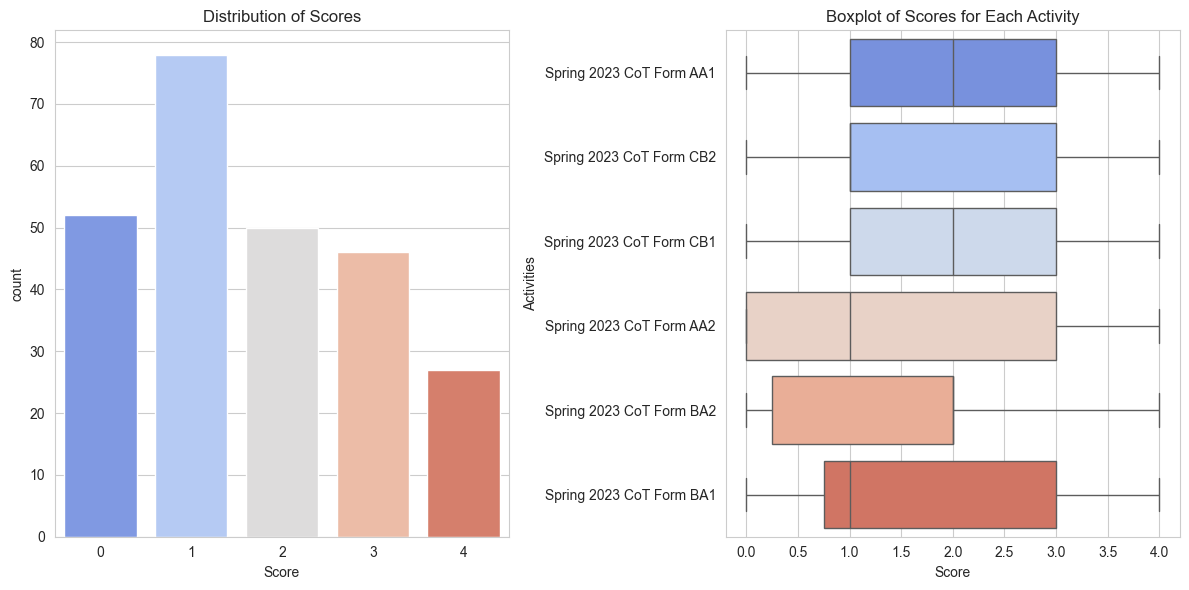

In [119]:
# Data analysis by graphing the distribution of scores 
# Show the following graph horizontally:
# 1. Distribution of scores
# 2. Boxplot of scores for each activity
import matplotlib.pyplot as plt
import seaborn as sns

# turn off the warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=pd.unique(df['Score']), y=df['Score'].value_counts(), palette="coolwarm", ax=axes[0])
axes[0].set_xlabel('Score')
axes[0].set_title('Distribution of Scores')

sns.boxplot(data=df, x='Score', y='Activities', palette="coolwarm", ax=axes[1])
axes[1].set_title('Boxplot of Scores for Each Activity')

plt.tight_layout()

plt.show()



In [146]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
#from transformers.modeling_distilbert import DistilBertModel, DistilBertPreTrainedModel
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


class MultimodalRoberta(DistilBertPreTrainedModel):
    def __init__(self, config, num_labels=5):
        super(MultimodalRoberta, self).__init__(config)
        self.num_labels = num_labels
        self.roberta1 = RobertaModel(config)
        self.roberta2 = RobertaModel(config)
        self.roberta3 = RobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size * 3, num_labels)
        self.init_weights()

    def forward(self, input_ids1, input_ids2, input_ids3, attention_mask1=None, attention_mask2=None, attention_mask3=None):
        outputs1 = self.roberta1(input_ids1, attention_mask=attention_mask1)
        outputs2 = self.roberta2(input_ids2, attention_mask=attention_mask2)
        outputs3 = self.roberta3(input_ids3, attention_mask=attention_mask3)
        pooled_output1 = outputs1[1]
        pooled_output2 = outputs2[1]
        pooled_output3 = outputs3[1]

        pooled_output_1 = self.dropout(pooled_output_1)
        pooled_output_2 = self.dropout(pooled_output_2)
        pooled_output_3 = self.dropout(pooled_output_3)

        logits = self.classifier(torch.cat((pooled_output_1, pooled_output_2, pooled_output_3), dim=1))

        outputs = (logits,) + outputs1[2:] + outputs2[2:] + outputs3[2:]

        return outputs  # (loss), logits, (hidden_states), (attentions)

    
class MultimodalRobertaDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.columns = ["Market.01a_OE", "Market.01b_OE", "Market.01c_OE"]
        self.labels = self.df['Score'].values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sentence1 = str(self.df.loc[index, self.columns[0]])
        sentence2 = str(self.df.loc[index, self.columns[1]])
        sentence3 = str(self.df.loc[index, self.columns[2]])

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sentence1, sentence2, sentence3, 
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=128,  
                                      return_tensors='pt')
        
        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids

        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values

        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        return token_ids, attn_masks, token_type_ids, self.labels[index]
    
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = MultimodalRobertaDataset(
        df=df,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)

np.random.seed(seed_val)

torch.manual_seed(seed_val)

torch.cuda.manual_seed_all(seed_val)

# Get the lists of sentences and their labels.
sentences1 = df['Market.01a_OE'].values
sentences2 = df['Market.01b_OE'].values
sentences3 = df['Market.01c_OE'].values

labels = df['Score'].values

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids1 = []
input_ids2 = []
input_ids3 = []

# For every sentence...

for sent1, sent2, sent3 in zip(sentences1, sentences2, sentences3):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.

    encoded_sent1 = tokenizer.encode(
        sent1,  # Sentence to encode.
        add_special = True,
        max_length=128,  # Truncate all sentences.
        truncation=True,  # Truncate all sentences.
        padding='max_length',  # Pad all sentences.
        return_tensors='pt',  # Return pytorch tensors.
    )

    encoded_sent2 = tokenizer.encode(
        sent2,  # Sentence to encode.
        add_special = True,
        max_length=128,  # Truncate all sentences.
        truncation=True,  # Truncate all sentences.
        padding='max_length',  # Pad all sentences.
        return_tensors='pt',  # Return pytorch tensors.
    )

    encoded_sent3 = tokenizer.encode(
        sent3,  # Sentence to encode.
        add_special = True,
        max_length=128,  # Truncate all sentences.
        truncation=True,  # Truncate all sentences.
        padding='max_length',  # Pad all sentences.
        return_tensors='pt',  # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids1.append(encoded_sent1)

    input_ids2.append(encoded_sent2)
    input_ids3.append(encoded_sent3)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences1[0])
print('Token IDs:', input_ids1[0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences2[0])
print('Token IDs:', input_ids2[0])

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences3[0])
print('Token IDs:', input_ids3[0])

# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the required sequence length.
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids1 = pad_sequences(input_ids1, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

input_ids2 = pad_sequences(input_ids2, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")

input_ids3 = pad_sequences(input_ids3, maxlen=MAX_LEN, dtype="long",
                            value=0, truncating="post", padding="post")

print('\nDone.')



KeyError: 185

In [ ]:
# train the model
# Set the batch size.
batch_size = 8

# split the dataset 
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
# Create the DataLoader.
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, batch_size)

# Load BertForSequenceClassification, the pretrained BERT model with a single
